In [1]:
# https://www.mdpi.com/2076-3417/12/19/10077

In [2]:
import os
# !pwd

from pathlib import Path

dir_path = Path(r"/Users/rabinatwayana/Rabina/CDE II/Wildfire Project/SAR-Burnt-Area-Mapping/")

if dir_path.exists():
    os.chdir(dir_path)
else:
    print("Directory does not exist! Please check the path.")

In [3]:
import geopandas as gpd
import rasterio
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report,ConfusionMatrixDisplay,\
                            precision_score,recall_score,f1_score,roc_auc_score, roc_curve

import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore") 
warnings.filterwarnings("ignore", category=UserWarning)
import joblib
import os
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
from utils import evaluate_model, run_model, create_fish_net, prepare_training_sample,get_best_hyperparameter
import config
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

TILE_SIZE=config.TILE_SIZE
# PALISADE_CLIP_EXTENT=config.PALISADE_CLIP_EXTENT

In [4]:
metrics_combined=[]
hyperparameter_tuning=True
# tile_size=100
gt_image_path="MachineLearning/input/ground_truth/02_gt/gt_palisade.tif"
rgb_image_path="MachineLearning/input/S2/rgbn_clip.tif"


113


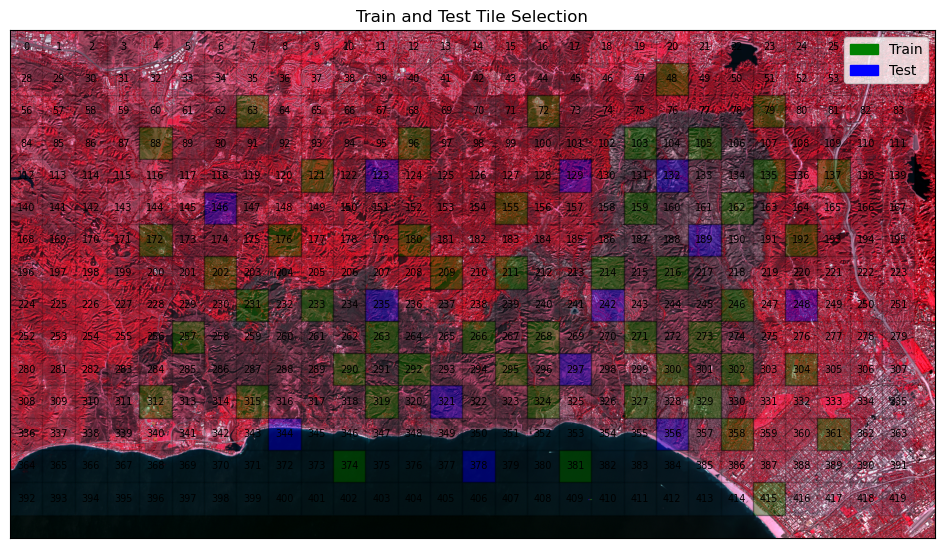

Fishnet tile generation done


In [5]:
#old clip extent
# train_ids = [218,149,172,153,246,352,305,308, 372,411,381,441,406,317,250,252,220,280,418,475,481,124,256,452,237,243,215,114,107,175,370,85,436,303,347,376,388,374,379,340,77]
# test_ids = [284,185, 319,345,342, 479,321,178,368,88,239,384,410,188,315,444]

train_ids = [135,88,172,361,63,79,300,211,315,257,202,176,180,209,155,96,121,72,48,137,192,304,358,374,381,103,105,159,162,214,216,246,271,273,302,268,295,266,292,290,233,319,324,231,329,327,263,312,415]
test_ids = [146,129,123,344,378,248,132,189,242,297,321,235,356]
# train_ids = [250,338,128,414,388,312,135,88,172,361,63,79,300,211,315,257,202,176,179,209,154,97,121,48,137,192,304,358,374,381,103,105,159,162,214,216,246,271,273,302,268,295,266,289,233,319,324,259,329,327,264]
# test_ids = [81,73,146,123,344,378,248,132,189,241,297,321,235,356,286]

tiles=create_fish_net("MachineLearning/input/sar/02_clip/S1A_asc_32611_avg_clip.tif", rgb_image_path, tile_size=TILE_SIZE,plot_fig=True,train_ids=train_ids,test_ids=test_ids)



### Model best hyperparameter selection

In [6]:

# RF_Model_1=RandomForestClassifier(n_estimators= 300, min_samples_split= 40, max_features= 2,max_depth= 10,bootstrap=True)
# RF_Model_2=RandomForestClassifier(n_estimators= 100,max_samples=0.3, class_weight="balanced_subsample",min_samples_split= 40, max_features= 2,max_depth= 10,bootstrap=True)
# RF_Model_3=RandomForestClassifier(n_estimators= 100,max_samples=0.5, class_weight="balanced_subsample",bootstrap=True,n_jobs=-1)
# RF_Model_4=RandomForestClassifier(n_estimators= 100,max_samples=0.5, class_weight="balanced",bootstrap=True,n_jobs=-1) 

#Through model selection
# {'n_estimators': 150, 'min_samples_split': 20, 'max_samples': 0.3, 'max_features': 'sqrt', 'max_depth': 20, 'class_weight': 'balanced'}
# RF_Model=RandomForestClassifier(
#     n_estimators= 150, 
#     class_weight="balanced",
#     max_samples= 0.3, 
#     min_samples_split= 20, 
#     max_features= 'sqrt',
#     max_depth=20,
#     bootstrap=True)

# 100,20,0.3
# {'n_estimators': 150, 'min_samples_split': 10, 'max_samples': 0.7, 'max_features': 4, 'max_depth': 10, 'class_weight': 'balanced_subsample'}
# RF_Model=RandomForestClassifier(
#     n_estimators= 150, 
#     class_weight="balanced_subsample",
#     max_samples= 0.7, 
#     min_samples_split= 10, 
#     max_features= 4,
#     max_depth=10,
#     bootstrap=True)
# # models={
# #     "RandomForest": RF_Model,
# # }
# model_name="RandomForest"
# model=RF_Model

In [7]:
# scheme_0=False
scheme_1 = True
scheme_2 =True
scheme_3 =True
scheme_4 =True

scheme_5 =True
scheme_6 =True
scheme_7 =True
scheme_8 =True


# scheme_6 =False
# scheme_7 =False
# drop_columns=['x','y','class']
# class_column_name='class'
# drop_columns=['geometry','Dnbr1','id','class']
# corr_mat_dir="MachineLearning/output/correlation/"


## Model best hyper parameter selection

In [8]:
# tune_train_ids = [146,129,123,344,378,248,132,189,242,297,321,235,356,274,231,290,49,409,193,287,208]
# tune_train_ids=test_ids

# random_search_model = XGBClassifier(random_state=42)
# params = {
#     'n_estimators': [50, 100, 150],  # Number of boosting rounds (trees)
#     'max_depth': [10, 20, 30],  # Maximum depth of trees
#     'learning_rate': [0.01, 0.05, 0.1],  # Step size shrinking to prevent overfitting
#     'min_child_weight': [1, 5, 10],  # Minimum sum of instance weight (hessian) in a child
#     'subsample': [0.3, 0.5, 0.7],  # Fraction of samples used for each tree
#     'colsample_bytree': [0.3, 0.5, 0.7],  # Fraction of features to consider for each tree
#     'colsample_bylevel': [0.3, 0.5, 0.7],  # Fraction of features to consider for each level
#     'gamma': [0, 1, 5],  # Minimum loss reduction required to make a further partition
#     'scale_pos_weight': [1, 10, 20],  # Adjusts for imbalanced classes
#     'reg_alpha': [0, 0.1, 1],  # L1 regularization term on weights (similar to Lasso)
#     'reg_lambda': [1, 10, 100],  # L2 regularization term on weights (similar to Ridge)
#     'objective': ['binary:logistic'],  # Specify binary classification objective
#     'booster': ['gbtree', 'dart', 'gblinear'],  # Types of boosters: gbtree, dart, or gblinear
#     'eval_metric': ['logloss', 'error'],  # Evaluation metrics
#     'scale_pos_weight': [1, 10, 50],  # Scaling factor for imbalanced classes
#     'max_delta_step': [0, 1, 10],  # Maximum delta step for tree growing
#     'tree_method': ['auto', 'exact', 'approx', 'hist', 'gpu_hist'],  # Tree construction algorithm
# }

params = {
        'n_estimators': [50, 100, 150],  # Number of trees
        'max_depth': [10, 20,30],  # Depth of trees
        'min_samples_split': [10, 20, 40],  # Minimum samples to split
        'max_features': [2, 4, 'sqrt', 'log2'],  # Features to consider at each split
        'class_weight': ['balanced_subsample', 'balanced'],  # Handle class imbalance
        'max_samples': [0.3,0.5, 0.7],
        # "min_samples_leaf": [1, 5, 20],
        # "criterion": ["gini", "entropy"],
        "bootstrap":[True,False]  # Fraction of samples to train each tree on
    }
random_search_model = RandomForestClassifier(random_state=42)



# print("scheme_1********************")
# feature_image_path=f"MachineLearning/output/feature_image/palisades_sar_avg_asc.tif"
# get_best_hyperparameter(random_search_model,feature_image_path,gt_image_path,params,tune_train_ids,TILE_SIZE)

# print("scheme_2**********************")
# feature_image_path=f"MachineLearning/output/feature_image/palisades_sar_avg_desc.tif"
# get_best_hyperparameter(random_search_model,feature_image_path,gt_image_path,params,tune_train_ids,TILE_SIZE)

# print("scheme_3***********************")
# feature_image_path=f"MachineLearning/output/feature_image/palisades_sar_avg_asc_desc.tif"
# get_best_hyperparameter(random_search_model,feature_image_path,gt_image_path,params,tune_train_ids,TILE_SIZE)

# print("scheme_4************************")
# feature_image_path=f"MachineLearning/output/feature_image/palisades_sar_avg_asc_desc_glcm.tif"
# get_best_hyperparameter(random_search_model,feature_image_path,gt_image_path,params,tune_train_ids,TILE_SIZE)

# # print("scheme_5*************************")
# # feature_image_path=f"MachineLearning/output/feature_image/palisades_sar_glcm.tif"
# # get_best_hyperparameter(feature_image_path,gt_image_path,params,tune_train_ids,TILE_SIZE)



In [9]:
# # scheme_1_best_param={'n_estimators': 150, 'min_samples_split': 10, 'max_samples': 0.5, 'max_features': 4, 'max_depth': 20, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'bootstrap': True} #'min_samples_leaf': 1,
# scheme_1_best_param={'n_estimators': 150, 'min_samples_split': 10, 'max_samples': 0.5, 'max_features': 4, 'max_depth': 15, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'bootstrap': True} #'min_samples_leaf': 1,
# # test: {'n_estimators': 50, 'min_samples_split': 10, 'max_samples': 0.3, 'max_features': 'log2', 'max_depth': 10, 'class_weight': 'balanced','bootstrap'=True}
# # {'n_estimators': 50, 'min_samples_split': 20, 'max_samples': 0.3, 'max_features': 'sqrt', 'max_depth': 10, 'class_weight': 'balanced',bootstrap=True}
# scheme_1_model=RandomForestClassifier(**scheme_1_best_param)

# # scheme_2_best_param={'n_estimators': 150, 'min_samples_split': 10, 'max_samples': 0.5, 'max_features': 4, 'max_depth': 30, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'bootstrap': True} # 'min_samples_leaf': 5,
# scheme_2_best_param={'n_estimators': 150, 'min_samples_split': 10, 'max_samples': 0.5, 'max_features': 4, 'max_depth': 15, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'bootstrap': True} # 'min_samples_leaf': 5,
# # {'n_estimators': 100, 'min_samples_split': 10, 'max_samples': 0.5, 'max_features': 'log2', 'max_depth': 20, 'class_weight': 'balanced',bootstrap=True}
# # {'n_estimators': 100, 'min_samples_split': 10, 'max_samples': 0.5, 'max_features': 2, 'max_depth': 20, 'class_weight': 'balanced_subsample',bootstrap=True}
# scheme_2_model=RandomForestClassifier(**scheme_2_best_param)

# scheme_3_best_param={'n_estimators': 150, 'min_samples_split': 10, 'max_samples': 0.5, 'max_features': 4, 'max_depth': 15, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'bootstrap': True} # 'min_samples_leaf': 5,
# # scheme_3_best_param={'n_estimators': 150, 'min_samples_split': 10, 'max_samples': 0.5, 'max_features': 4, 'max_depth': 30, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'bootstrap': True} # 'min_samples_leaf': 5,
# # {'n_estimators': 50, 'min_samples_split': 20, 'max_samples': 0.3, 'max_features': 'log2', 'max_depth': 10, 'class_weight': 'balanced_subsample',bootstrap=True}
# # {'n_estimators': 100, 'min_samples_split': 10, 'max_samples': 0.5, 'max_features': 'log2', 'max_depth': 10, 'class_weight': 'balanced_subsample'}
# # test:{'n_estimators': 50, 'min_samples_split': 20, 'max_samples': 0.3, 'max_features': 'log2', 'max_depth': 10, 'class_weight': 'balanced_subsample'}
# # {'n_estimators': 100, 'min_samples_split': 10, 'max_samples': 0.7, 'max_features': 2, 'max_depth': 30, 'class_weight': 'balanced'}
# scheme_3_model=RandomForestClassifier(**scheme_3_best_param)

# # scheme_4_best_param= {'n_estimators': 100, 'min_samples_split': 10,  'max_samples': 0.7, 'max_features': 'log2', 'max_depth': 30, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'bootstrap': True} #'min_samples_leaf': 1,
# scheme_4_best_param= {'n_estimators': 100, 'min_samples_split': 10,  'max_samples': 0.7, 'max_features': 'log2', 'max_depth': 15, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'bootstrap': True} #'min_samples_leaf': 1,
# # {'n_estimators': 100, 'min_samples_split': 10, 'max_samples': 0.5, 'max_features': 'sqrt', 'max_depth': 20, 'class_weight': 'balanced',bootstrap=True}
# # train:{'n_estimators': 150, 'min_samples_split': 10, 'max_samples': 0.7, 'max_features': 'sqrt', 'max_depth': 20, 'class_weight': 'balanced'}
# scheme_4_model=RandomForestClassifier(**scheme_4_best_param)

# scheme_5_best_param={}
# # {'n_estimators': 150, 'min_samples_split': 10, 'max_samples': 0.5, 'max_features': 2, 'max_depth': 10, 'class_weight': 'balanced',bootstrap=True}
# # {'n_estimators': 150, 'min_samples_split': 10, 'max_samples': 0.5, 'max_features': 4, 'max_depth': 10, 'class_weight': 'balanced_subsample'}
# scheme_5_model=RandomForestClassifier( **scheme_5_best_param)



In [10]:
## Final hypertuned RF Model
model_name="RandomForest"

RF_Model=RandomForestClassifier(
    n_estimators= 150, 
    class_weight="balanced_subsample",
    # class_weight={0:0.5, 1:3},
    # class_weight={0:1, 1:5},
    max_samples= 0.7, 
    min_samples_split= 10, 
    max_features= 4,
    max_depth=15,
    bootstrap=True)

# rf_best_params={'n_estimators': 100, 'min_samples_split': 10, 'max_samples': 0.7, 'max_features': 'log2', 'max_depth': 15, 'class_weight': 'balanced_subsample', 'bootstrap': True}
# RF_Model=RandomForestClassifier(**rf_best_params)
model=RF_Model

In [11]:
## best param
# xgboost_best_param={'tree_method': 'hist', 
#  'subsample': 0.7, 
#  'scale_pos_weight': 1, 
#  'reg_lambda': 1, 'reg_alpha': 1,
#   'objective': 'binary:logistic',
#   'n_estimators': 150,
#   'min_child_weight': 1,
#   'max_depth': 30,
#   'max_delta_step': 1,
#   'learning_rate': 0.05, 
#   'gamma': 1, 
#   'eval_metric': 'error', 
#   'colsample_bytree': 0.7, 
#   'colsample_bylevel': 0.7, 
#   'booster': 'dart'}

# # chatgpt
# xgboost_best_param = {
#     'booster': 'dart',
#     'tree_method': 'hist',
#     'objective': 'binary:logistic',
#     'eval_metric': 'logloss',  # more informative than 'error'
    
#     'learning_rate': 0.03,          # slightly lower
#     'n_estimators': 300,            # compensate with more rounds
#     'early_stopping_rounds': 30,    # use during training with eval_set
    
#     'max_depth': 8,                 # significantly lower depth
#     'min_child_weight': 5,          # more conservative splitting
#     'gamma': 2,                     # increase for more pruning
    
#     'subsample': 0.7,
#     'colsample_bytree': 0.7,
#     'colsample_bylevel': 0.7,

#     'reg_lambda': 5,                # increase L2 regularization
#     'reg_alpha': 2,                 # increase L1 regularization

#     'scale_pos_weight': 1,          # adjust only if classes are imbalanced
#     'max_delta_step': 1
# }


# XGBClassifier_Model=XGBClassifier(**xgboost_best_param)

# model=XGBClassifier_Model
# model_name="XGB"

In [12]:
output_model_dir="MachineLearning/output/model/"
output_feat_imp_dir="MachineLearning/output/feature_importance/"
feature_column_names=["RBD_VV", "RBD_VH", "RBR_VV", "RBR_VH","ΔRVI"]
feature_column_names_with_glcm=["RBD_VV", "RBD_VH", "RBR_VV", "RBR_VH","ΔRVI",'p1','p2','p3']
glcm_feature_column_names=['p1','p2','p3']
# gt_image_path="MachineLearning/input/ground_truth/02_gt/gt_palisade.tif"

******* scheme 1 *********
***************RandomForest*********************
Fishnet tile generation done
(490000, 5) (490000,) hbfhsdvchsdvch
Model performance for Training set smooth
Model performance
- Log loss: 5.354027256286289
- Accuracy: 0.8514571428571429
- F1 Score: 0.8502449525428902
- Precision Score: 0.8520467354137082
- Recall Score: 0.8514571428571429
- Roc Auc Score: 0.8417549153027034
- confusion_matrix: [[255341  26293]
 [ 46493 161873]]
--------------
Model performance for Test set smooth
Model performance
- Log loss: 7.043484389977941
- Accuracy: 0.8045846153846153
- F1 Score: 0.801237463167992
- Precision Score: 0.8080648676943272
- Recall Score: 0.8045846153846153
- Roc Auc Score: 0.7903709688209356
- confusion_matrix: [[66077  7686]
 [17718 38519]]
----------------------------------------
Model saved successfully!
******* scheme 2 *********
***************RandomForest*********************
Fishnet tile generation done
(490000, 5) (490000,) hbfhsdvchsdvch
Model perfo

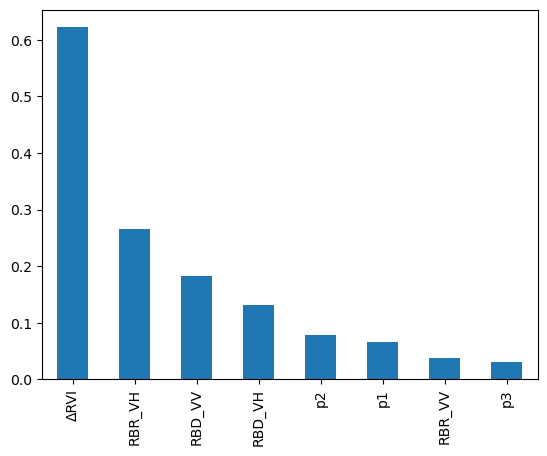

In [13]:
if scheme_1:
    print("******* scheme 1 *********")
    file_name="palisades_sar_single_asc"
    metrics_1=run_model(
            feature_image_path=f"MachineLearning/output/feature_image/{file_name}.tif", 
              gt_image_path=gt_image_path,
            #   sample_feature_path=f"MachineLearning/output/sample_feature/{file_name}.csv", 
              feature_column_names=feature_column_names, 
            #   drop_columns=drop_columns, 
            #   class_column_name=class_column_name ,
            model_name=model_name,
              model=model, #scheme_3_model,
              output_model_dir=output_model_dir,
               output_feat_imp_dir=output_feat_imp_dir,
            #    corr_mat_dir=corr_mat_dir,
               extended_file_name=f"_{file_name}",
               train_ids=train_ids, 
               test_ids=test_ids, 
               tile_size=TILE_SIZE
               )
    metrics_combined.append(metrics_1)

if scheme_2:
    print("******* scheme 2 *********")
    
    #1 Asc glcm
    file_name="palisades_sar_single_desc"
    metrics_2=run_model(feature_image_path=f"MachineLearning/output/feature_image/{file_name}.tif", 
              gt_image_path=gt_image_path,
              # sample_feature_path=f"MachineLearning/output/sample_feature/{file_name}.csv", 
              feature_column_names=feature_column_names, 
            #   drop_columns=drop_columns, 
            #   class_column_name=class_column_name ,
             
              model_name=model_name,
              model=model, #scheme_3_model,
              output_model_dir=output_model_dir,
               output_feat_imp_dir=output_feat_imp_dir,
            #    corr_mat_dir=corr_mat_dir,
               extended_file_name=f"_{file_name}",
               train_ids=train_ids, 
               test_ids=test_ids, 
               tile_size=TILE_SIZE
               )
    metrics_combined.append(metrics_2)


if scheme_3:
    print("******* scheme 3 *********")
    
    #1 Asc avg
    file_name="palisades_sar_single_asc_desc"
    metrics_3=run_model(feature_image_path=f"MachineLearning/output/feature_image/{file_name}.tif", 
              gt_image_path=gt_image_path,
              
              # sample_feature_path=f"MachineLearning/output/sample_feature/{file_name}.csv", 
              feature_column_names=feature_column_names, 
            #   drop_columns=drop_columns, 
            #   class_column_name=class_column_name ,
              model_name=model_name,
              model=model, #scheme_3_model,
              output_model_dir=output_model_dir,
               output_feat_imp_dir=output_feat_imp_dir,
            #    corr_mat_dir=corr_mat_dir,
               extended_file_name=f"_{file_name}",
               train_ids=train_ids, 
               test_ids=test_ids, 
               tile_size=TILE_SIZE
               )
    metrics_combined.append(metrics_3)
    
    
if scheme_4:
    print("******* scheme 4 *********")
    
    #1 Asc avg + glcm
    file_name="palisades_sar_single_asc_desc_glcm"
    metrics_4=run_model(feature_image_path=f"MachineLearning/output/feature_image/{file_name}.tif", 
              gt_image_path=gt_image_path,
              
              # sample_feature_path=f"MachineLearning/output/sample_feature/{file_name}.csv", 
              feature_column_names=feature_column_names_with_glcm, 
            #   drop_columns=drop_columns, 
            #   class_column_name=class_column_name ,
              model_name=model_name,
              model=model, #scheme_3_model,
              output_model_dir=output_model_dir,
               output_feat_imp_dir=output_feat_imp_dir,
            #    corr_mat_dir=corr_mat_dir,
               extended_file_name=f"_{file_name}",
               train_ids=train_ids, 
               test_ids=test_ids, 
               tile_size=TILE_SIZE
               )
    metrics_combined.append(metrics_4)

if scheme_5:
    print("******* scheme 5 *********")
    file_name="palisades_sar_avg_asc"
    metrics_5=run_model(
            feature_image_path=f"MachineLearning/output/feature_image/{file_name}.tif", 
              gt_image_path=gt_image_path,
            #   sample_feature_path=f"MachineLearning/output/sample_feature/{file_name}.csv", 
              feature_column_names=feature_column_names, 
            #   drop_columns=drop_columns, 
            #   class_column_name=class_column_name ,
            model_name=model_name,
              model=model, #scheme_3_model,
              output_model_dir=output_model_dir,
               output_feat_imp_dir=output_feat_imp_dir,
            #    corr_mat_dir=corr_mat_dir,
               extended_file_name=f"_{file_name}",
               train_ids=train_ids, 
               test_ids=test_ids, 
               tile_size=TILE_SIZE
               )
    metrics_combined.append(metrics_5)

if scheme_6:
    print("******* scheme 6 *********")
    
    #1 Asc glcm
    file_name="palisades_sar_avg_desc"
    metrics_6=run_model(feature_image_path=f"MachineLearning/output/feature_image/{file_name}.tif", 
              gt_image_path=gt_image_path,
              # sample_feature_path=f"MachineLearning/output/sample_feature/{file_name}.csv", 
              feature_column_names=feature_column_names, 
            #   drop_columns=drop_columns, 
            #   class_column_name=class_column_name ,
             
              model_name=model_name,
              model=model, #scheme_3_model,
              output_model_dir=output_model_dir,
               output_feat_imp_dir=output_feat_imp_dir,
            #    corr_mat_dir=corr_mat_dir,
               extended_file_name=f"_{file_name}",
               train_ids=train_ids, 
               test_ids=test_ids, 
               tile_size=TILE_SIZE
               )
    metrics_combined.append(metrics_6)


if scheme_7:
    print("******* scheme 7 *********")
    
    #1 Asc avg
    file_name="palisades_sar_avg_asc_desc"
    metrics_7=run_model(feature_image_path=f"MachineLearning/output/feature_image/{file_name}.tif", 
              gt_image_path=gt_image_path,
              
              # sample_feature_path=f"MachineLearning/output/sample_feature/{file_name}.csv", 
              feature_column_names=feature_column_names, 
            #   drop_columns=drop_columns, 
            #   class_column_name=class_column_name ,
              model_name=model_name,
              model=model, #scheme_3_model,
              output_model_dir=output_model_dir,
               output_feat_imp_dir=output_feat_imp_dir,
            #    corr_mat_dir=corr_mat_dir,
               extended_file_name=f"_{file_name}",
               train_ids=train_ids, 
               test_ids=test_ids, 
               tile_size=TILE_SIZE
               )
    metrics_combined.append(metrics_7)
    
if scheme_8:
    print("******* scheme 8 *********")
    
    #1 Asc avg + glcm
    file_name="palisades_sar_avg_asc_desc_glcm"
    metrics_8=run_model(feature_image_path=f"MachineLearning/output/feature_image/{file_name}.tif", 
              gt_image_path=gt_image_path,
              
              # sample_feature_path=f"MachineLearning/output/sample_feature/{file_name}.csv", 
              feature_column_names=feature_column_names_with_glcm, 
            #   drop_columns=drop_columns, 
            #   class_column_name=class_column_name ,
              model_name=model_name,
              model=model, #scheme_3_model,
              output_model_dir=output_model_dir,
               output_feat_imp_dir=output_feat_imp_dir,
            #    corr_mat_dir=corr_mat_dir,
               extended_file_name=f"_{file_name}",
               train_ids=train_ids, 
               test_ids=test_ids, 
               tile_size=TILE_SIZE
               )
    metrics_combined.append(metrics_8)
    

# if scheme_5:
#     print("******* scheme 5 *********")
    
#     #avg asc + desc
#     file_name="palisades_sar_glcm"
#     metrics_5=run_model(feature_image_path=f"MachineLearning/output/feature_image/{file_name}.tif",
#               gt_image_path=gt_image_path,
               
#               # sample_feature_path=f"MachineLearning/output/sample_feature/{file_name}.csv", 
#               feature_column_names=glcm_feature_column_names, 
#               # drop_columns=drop_columns, 
#               # class_column_name=class_column_name ,
#               model_name=model_name,
#               model=model, #scheme_5_model,
#               output_model_dir=output_model_dir,
#               output_feat_imp_dir=output_feat_imp_dir,
#               #  corr_mat_dir=corr_mat_dir,
#                extended_file_name=f"_{file_name}",
#               train_ids=train_ids, 
#                test_ids=test_ids, 
#                tile_size=TILE_SIZE
               
#                )
#     metrics_combined.append(metrics_5)
   
    
# if scheme_6:
#     #avg asc + desc + glcm
#     file_name="palisades_sar_avgasc_desc_glcm"
#     run_model(feature_image_path=f"MachineLearning/output/feature_image/{file_name}.tif", 
#               gt_image_path=gt_image_path,
              
#               sample_feature_path=f"MachineLearning/output/sample_feature/{file_name}.csv", 
#               feature_column_names=feature_column_names_with_glcm, 
#               drop_columns=drop_columns, 
#               class_column_name=class_column_name,
#               models=models,
#               output_model_dir=output_model_dir,
#                output_feat_imp_dir=output_feat_imp_dir,
#                corr_mat_dir=corr_mat_dir,
#                extended_file_name=f"_{file_name}")
    
   

In [14]:

print(metrics_combined)
# Convert to DataFrame
df_metrics = pd.DataFrame(metrics_combined)

# Save to CSV
df_metrics.to_csv(f'MachineLearning/output/{model_name}evaluation_metrics_.csv', index=False)

print("CSV file created successfully!")

[{'acc_train': 0.8515, 'f1_train': 0.8502, 'precision_train': 0.852, 'recall_train': 0.8515, 'roc_auc_train': np.float64(0.8418), 'acc_test': 0.8046, 'f1_test': 0.8012, 'precision_test': 0.8081, 'recall_test': 0.8046, 'roc_auc_test': np.float64(0.7904)}, {'acc_train': 0.84, 'f1_train': 0.8386, 'precision_train': 0.8407, 'recall_train': 0.84, 'roc_auc_train': np.float64(0.8295), 'acc_test': 0.7912, 'f1_test': 0.7871, 'precision_test': 0.7953, 'recall_test': 0.7912, 'roc_auc_test': np.float64(0.7756)}, {'acc_train': 0.8878, 'f1_train': 0.8873, 'precision_train': 0.888, 'recall_train': 0.8878, 'roc_auc_train': np.float64(0.8812), 'acc_test': 0.8324, 'f1_test': 0.8298, 'precision_test': 0.8362, 'recall_test': 0.8324, 'roc_auc_test': np.float64(0.8195)}, {'acc_train': 0.897, 'f1_train': 0.8965, 'precision_train': 0.8973, 'recall_train': 0.897, 'roc_auc_train': np.float64(0.8906), 'acc_test': 0.8352, 'f1_test': 0.8329, 'precision_test': 0.8385, 'recall_test': 0.8352, 'roc_auc_test': np.float